# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br>
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br>

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# using SQLite Table to read data.

con = sqlite3.connect('drive/My Drive/database.sqlite')

# filtering only positive and negative reviews i.e.
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con)
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con)

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [ ]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br>
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br>
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order

sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

(87775, 10)

In [ ]:
final.sort_values('Time',inplace=True)
print(final.head(5))

          Id   ProductId          UserId    ProfileName  HelpfulnessNumerator  \
70688  76882  B00002N8SM  A32DW342WBJ6BX    Buttersugar                     0   
1146    1245  B00002Z754  A29Z5PI9BW2PU3         Robbie                     7   
1145    1244  B00002Z754  A3B8RCEI0FXFI6      B G Chase                    10   
28086  30629  B00008RCMI  A19E94CF5O1LY7  Andrew Arnold                     0   
28087  30630  B00008RCMI  A284C7M23F0APC     A. Mendoza                     0   

       HelpfulnessDenominator  Score        Time  \
70688                       0      1   948672000   
1146                        7      1   961718400   
1145                       10      1   962236800   
28086                       0      1  1067040000   
28087                       0      1  1067040000   

                                          Summary  \
70688                      A sure death for flies   
1146                                Great Product   
1145               WOW Make your own 'sli

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
we use this as the base, then besides the chicken, we will also add pasta, spices, veggies, or whatever we have around to make quick cheesy meals
My dogs just love this food. The service is always fast and reliable.
I am amazed by how well this tea works to relieve my chronic congestion and recurring sinus problems. And it's not just a "quick" fix either -- its therapeutic effects last for hours. I was a bit worried the tea would be a bit too "licorice-y" since one of its main ingredients is licorice root, but the fragrance and taste are mild and incredibly soothing. If you think this package of six boxes is too much, you'll be ha

In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
we use this as the base, then besides the chicken, we will also add pasta, spices, veggies, or whatever we have around to make quick cheesy meals
My dogs just love this food. The service is always fast and reliable.
I am amazed by how well this tea works to relieve my chronic congestion and recurring sinus problems. And it's not just a "quick" fix either -- its therapeutic effects last for hours. I was a bit worried the tea would be a bit too "licorice-y" since one of its main ingredients is licorice root, but the fragrance and taste are mild and incredibly soothing. If you think this package of six boxes is too much, you'll be happily prov

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

My dogs just love this food. The service is always fast and reliable.


In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

My dogs just love this food The service is always fast and reliable 


In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:30<00:00, 2871.61it/s]


In [ ]:
preprocessed_reviews[1500]

'dogs love food service always fast reliable'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [ ]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict ,
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin"
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))

elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8655084371566772), ('awesome', 0.8243688941001892), ('good', 0.8234603404998779), ('excellent', 0.812393069267273), ('wonderful', 0.8109457492828369), ('terrific', 0.7972511649131775), ('amazing', 0.761279821395874), ('perfect', 0.7559124827384949), ('nice', 0.7279060482978821), ('fabulous', 0.7102162837982178)]
[('greatest', 0.8000609278678894), ('best', 0.7185978889465332), ('nastiest', 0.7138915061950684), ('tastiest', 0.6618766784667969), ('coolest', 0.6550419330596924), ('closest', 0.6344001293182373), ('disgusting', 0.6197006702423096), ('horrible', 0.6178288459777832), ('terrible', 0.6117257475852966), ('experienced', 0.5961415767669678)]


In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 87773/87773 [02:32<00:00, 574.23it/s]

87773
50


#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 87773/87773 [35:11<00:00, 41.57it/s]


## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,random_state=0)

vectorizer = CountVectorizer()
vectorizer.fit(X_train_bow)
X_train_bow = vectorizer.transform(X_train_bow)
X_test_bow = vectorizer.transform(X_test_bow)

ss = StandardScaler(with_mean = False)
X_train_bow = ss.fit_transform(X_train_bow)
X_test_bow = ss.transform(X_test_bow)

print(X_train_bow.shape)
print(X_test_bow.shape)

(61441, 46010)
(26332, 46010)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 64.2min finished


Best HyperParameter:  {'n_neighbors': 13}


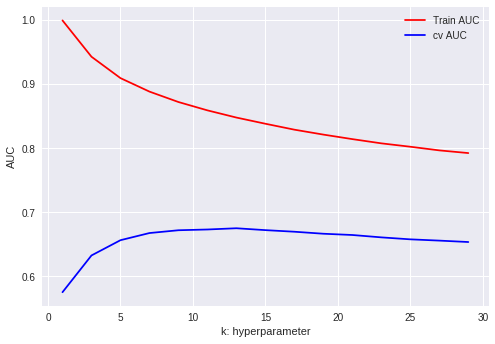

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

param = {'n_neighbors':np.arange(1,30,2)}
gs= GridSearchCV(knn,param,cv=3,verbose=1,scoring='roc_auc',n_jobs=-1)
gs.fit(X_train_bow,y_train_bow)
print("Best HyperParameter: ",gs.best_params_)

train_auc= gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score']

lines=plt.plot(param['n_neighbors'],train_auc,param['n_neighbors'], cv_auc)
plt.setp(lines[0],color='r',label='Train AUC')
plt.setp(lines[1],color='b',label='cv AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train_bow,y_train_bow)
y_pred_bow = knn.predict(X_test_bow)
y_pred_tr = knn.predict(X_train_bow)

acc=accuracy_score(y_test_bow, y_pred_bow)*100
ps=precision_score(y_test_bow, y_pred_bow)*100
rc=recall_score(y_test_bow, y_pred_bow)*100
f1=f1_score(y_test_bow, y_pred_bow)*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 84.25%
Precision on test set: 84.24%
recall score on test set: 99.93%
f1 score on test set: 91.41%


**Train confusion matrix**

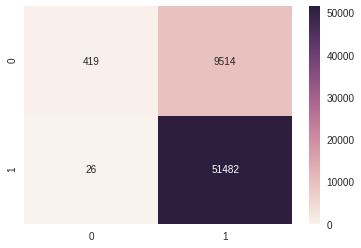

In [ ]:
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_train_bow, y_pred_tr), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

**Test confusion matrix**

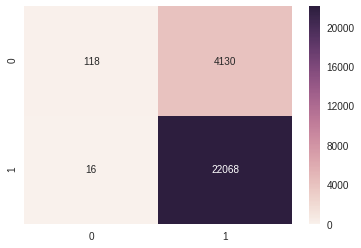

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_test_bow, y_pred_bow), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

train auc =0.8628537828440846
test auc=0.7125561884753675


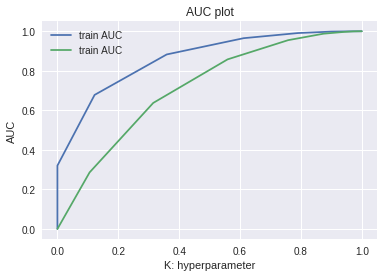

In [ ]:
from sklearn.metrics import roc_auc_score
train_fpr, train_tpr, thresholds = roc_curve(y_train_bow, knn.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_bow, knn.predict_proba(X_test_bow)[:,1])
print("train auc ={}".format(roc_auc_score(y_train_bow, knn.predict_proba(X_train_bow)[:,1])))
print("test auc={}".format(roc_auc_score(y_test_bow, knn.predict_proba(X_test_bow)[:,1])))

plt.plot(train_fpr, train_tpr, label="train AUC ")
plt.plot(test_fpr, test_tpr, label="train AUC ")
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC plot")
plt.show()

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [ ]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,random_state=0)

tf_idf_vect = TfidfVectorizer()
tf_idf_vect.fit(X_train_tf)

X_train_tf = tf_idf_vect.transform(X_train_tf)
X_test_tf = tf_idf_vect.transform(X_test_tf)

ss = StandardScaler(with_mean = False)
X_train_tf = ss.fit_transform(X_train_tf)
X_test_tf = ss.transform(X_test_tf)

print(X_train_tf.shape)
print(X_test_tf.shape)

(61441, 46010)
(26332, 46010)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 68.1min finished


Best HyperParameter:  {'n_neighbors': 3}


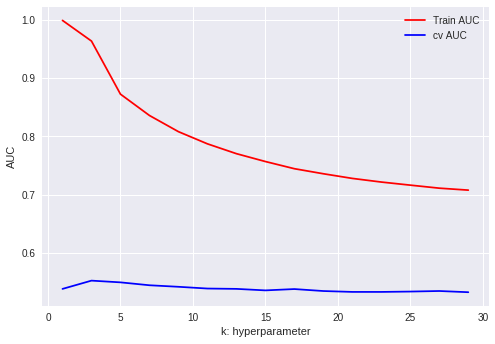

In [ ]:
knn = KNeighborsClassifier()

param = {'n_neighbors':np.arange(1,30,2)}
gs = GridSearchCV(knn,param,cv=3,verbose=1,scoring='roc_auc',n_jobs=-1)
gs.fit(X_train_tf,y_train_tf)
print("Best HyperParameter: ",gs.best_params_)

train_auc = gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score']

lines=plt.plot(param['n_neighbors'],train_auc,param['n_neighbors'], cv_auc)
plt.setp(lines[0],color='r',label='Train AUC')
plt.setp(lines[1],color='b',label='cv AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_tf,y_train_tf)
y_pred_tf = knn.predict(X_test_tf)
y_pred_tr = knn.predict(X_train_tf)

acc=accuracy_score(y_test_tf, y_pred_tf)*100
ps=precision_score(y_test_tf, y_pred_tf)*100
rc=recall_score(y_test_tf, y_pred_tf)*100
f1=f1_score(y_test_tf, y_pred_tf)*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 83.64%
Precision on test set: 84.59%
recall score on test set: 98.43%
f1 score on test set: 90.99%


**Train confusion matrix**

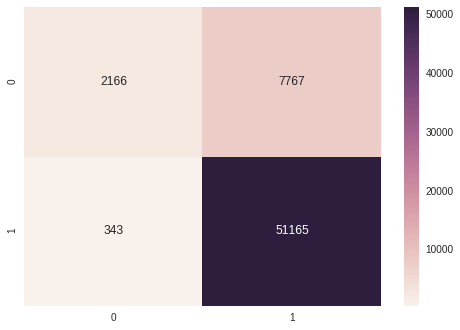

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_train_tf, y_pred_tr), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

**Test confusion matrix**

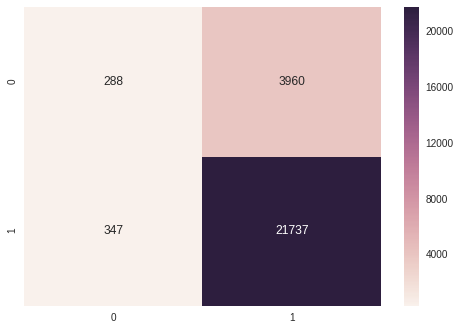

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_test_tf, y_pred_tf), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

train auc =0.9565985761900689
test auc=0.575357676016006


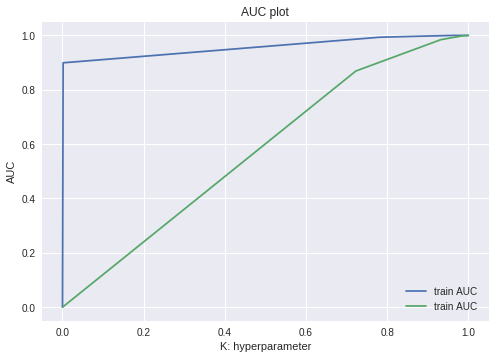

In [ ]:
train_fpr_tf, train_tpr_tf, thresholds_tf = roc_curve(y_train_tf, knn.predict_proba(X_train_tf)[:,1])
test_fpr_tf, test_tpr_tf, thresholds_tf = roc_curve(y_test_tf, knn.predict_proba(X_test_tf)[:,1])
print("train auc ={}".format(roc_auc_score(y_train_tf, knn.predict_proba(X_train_tf)[:,1])))
print("test auc={}".format(roc_auc_score(y_test_tf, knn.predict_proba(X_test_tf)[:,1])))

plt.plot(train_fpr_tf, train_tpr_tf, label="train AUC ")
plt.plot(test_fpr_tf, test_tpr_tf, label="train AUC ")
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC plot")
plt.show()

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
X_train_avg, X_test_avg, y_train_avg, y_test_avg = train_test_split(np.array(sent_vectors),final['Score'].values,test_size=0.3,random_state=0)

ss = StandardScaler(with_mean = False)
X_train_avg = ss.fit_transform(X_train_avg)
X_test_avg = ss.transform(X_test_avg)

print(X_train_avg.shape)
print(X_test_avg.shape)

(61441, 50)
(26332, 50)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 176.2min finished


Best HyperParameter:  {'n_neighbors': 29}


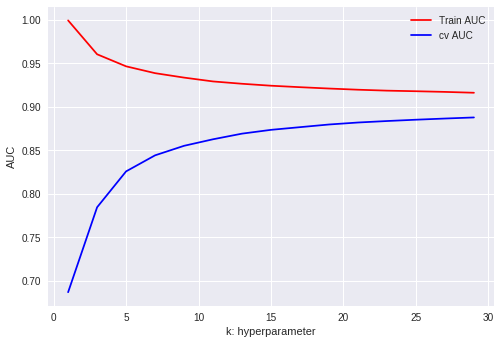

In [ ]:
knn = KNeighborsClassifier()

param = {'n_neighbors':np.arange(1,30,2)}
gs = GridSearchCV(knn,param,cv=3,verbose=1,scoring='roc_auc',n_jobs=-1)
gs.fit(X_train_avg,y_train_avg)
print("Best HyperParameter: ",gs.best_params_)

train_auc = gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score']

lines=plt.plot(param['n_neighbors'],train_auc,param['n_neighbors'], cv_auc)
plt.setp(lines[0],color='r',label='Train AUC')
plt.setp(lines[1],color='b',label='cv AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=29)
knn.fit(X_train_avg,y_train_avg)
y_pred_avg = knn.predict(X_test_avg)
y_pred_tr = knn.predict(X_train_avg)

acc=accuracy_score(y_test_avg, y_pred_avg)*100
ps=precision_score(y_test_avg, y_pred_avg)*100
rc=recall_score(y_test_avg, y_pred_avg)*100
f1=f1_score(y_test_avg, y_pred_avg)*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 87.69%
Precision on test set: 88.35%
recall score on test set: 98.28%
f1 score on test set: 93.05%


**Train confusion matrix**

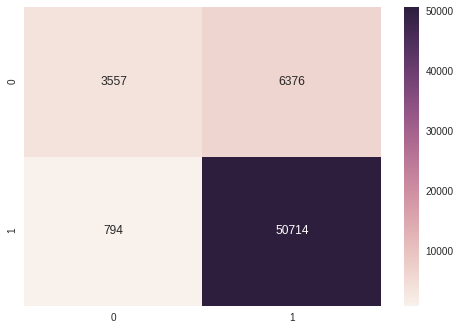

In [ ]:
cm= pd.DataFrame(confusion_matrix(y_train_avg, y_pred_tr), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

**Test confusion matrix**

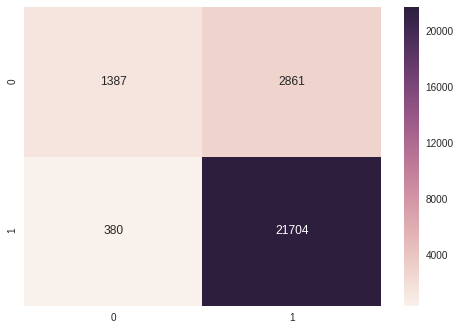

In [ ]:
cm= pd.DataFrame(confusion_matrix(y_test_avg, y_pred_avg), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

train auc =0.918516636208266
test auc=0.8890007179401641


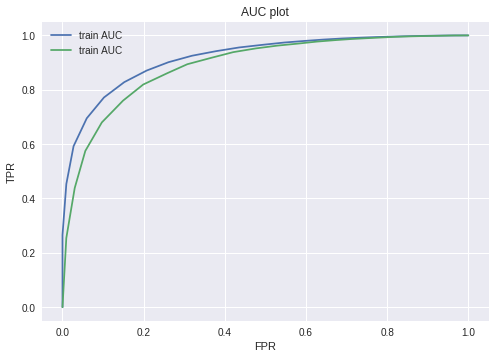

In [ ]:
train_fpr, train_tpr, thresholds = roc_curve(y_train_avg, knn.predict_proba(X_train_avg)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_avg, knn.predict_proba(X_test_avg)[:,1])
print("train auc ={}".format(roc_auc_score(y_train_avg, knn.predict_proba(X_train_avg)[:,1])))
print("test auc={}".format(roc_auc_score(y_test_avg, knn.predict_proba(X_test_avg)[:,1])))

plt.plot(train_fpr, train_tpr, label="train AUC ")
plt.plot(test_fpr, test_tpr, label="train AUC ")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC plot")
plt.show()

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
X_train_tw, X_test_tw, y_train_tw, y_test_tw = train_test_split(np.array(tfidf_sent_vectors),final['Score'].values,test_size=0.3,random_state=0)

ss = StandardScaler(with_mean = False)
X_train_tw = ss.fit_transform(X_train_tw)
X_test_tw = ss.transform(X_test_tw)

print(X_train_tw.shape)
print(X_test_tw.shape)

(61441, 50)
(26332, 50)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 150.3min finished


Best HyperParameter:  {'n_neighbors': 29}
Best Accuracy: 85.27%


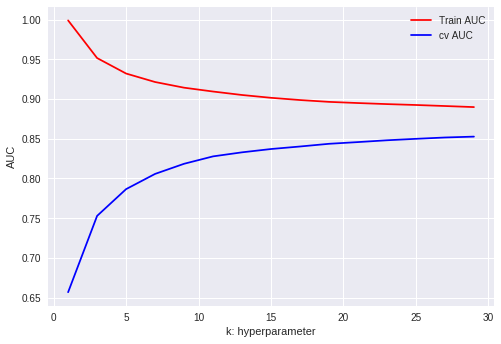

In [ ]:
knn = KNeighborsClassifier()

param = {'n_neighbors':np.arange(1,30,2)}
gs = GridSearchCV(knn,param,cv=3,verbose=1,scoring='roc_auc',n_jobs=-1)
gs.fit(X_train_tw,y_train_tw)
print("Best HyperParameter: ",gs.best_params_)
print("Best Accuracy: %.2f%%"%(gs.best_score_*100))

train_auc = gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score']

lines=plt.plot(param['n_neighbors'],train_auc,param['n_neighbors'], cv_auc)
plt.setp(lines[0],color='r',label='Train AUC')
plt.setp(lines[1],color='b',label='cv AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=29)
knn.fit(X_train_tw,y_train_tw)
y_pred_tw = knn.predict(X_test_tw)
y_pred_tr = knn.predict(X_train_tw)

acc=accuracy_score(y_test_tw, y_pred_tw)*100
ps=precision_score(y_test_tw, y_pred_tw)*100
rc=recall_score(y_test_tw, y_pred_tw)*100
f1=f1_score(y_test_tw, y_pred_tw)*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 86.88%
Precision on test set: 87.45%
recall score on test set: 98.50%
f1 score on test set: 92.64%


**Train confusion matrix**

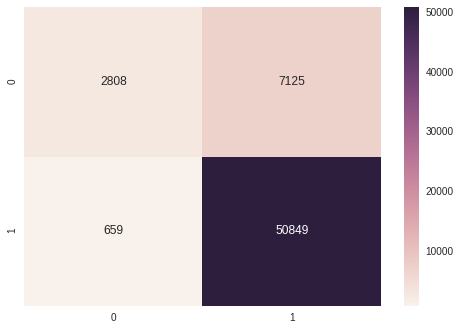

In [ ]:
cm= pd.DataFrame(confusion_matrix(y_train_tw, y_pred_tr), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

**Test confusion matrix**

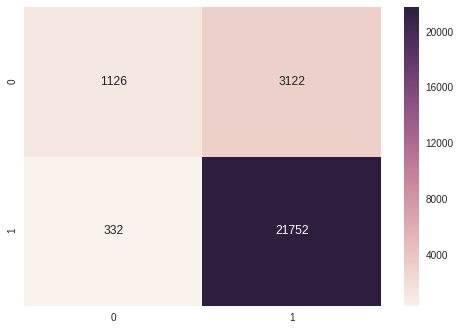

In [ ]:
cm= pd.DataFrame(confusion_matrix(y_test_tw, y_pred_tw), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

train auc =0.8949336896806336
test auc=0.8555597063736441


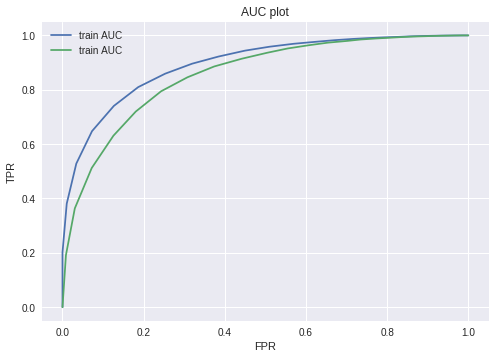

In [ ]:
train_fpr, train_tpr, thresholds = roc_curve(y_train_tw, knn.predict_proba(X_train_tw)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_tw, knn.predict_proba(X_test_tw)[:,1])
print("train auc ={}".format(roc_auc_score(y_train_tw, knn.predict_proba(X_train_tw)[:,1])))
print("test auc={}".format(roc_auc_score(y_test_tw, knn.predict_proba(X_test_tw)[:,1])))

plt.plot(train_fpr, train_tpr, label="train AUC ")
plt.plot(test_fpr, test_tpr, label="train AUC ")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC plot")
plt.show()

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,random_state=0)

vectorizer = CountVectorizer(min_df=10 , max_features=500)
vectorizer.fit(X_train_bow)
X_train_bow = vectorizer.transform(X_train_bow)
X_test_bow = vectorizer.transform(X_test_bow)

ss = StandardScaler(with_mean = False)
X_train_bow = ss.fit_transform(X_train_bow)
X_test_bow = ss.transform(X_test_bow)

print(X_train_bow.shape)
print(X_test_bow.shape)

(61441, 500)
(26332, 500)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 63.4min finished


Best HyperParameter:  {'n_neighbors': 29}
Best Accuracy: 76.82%


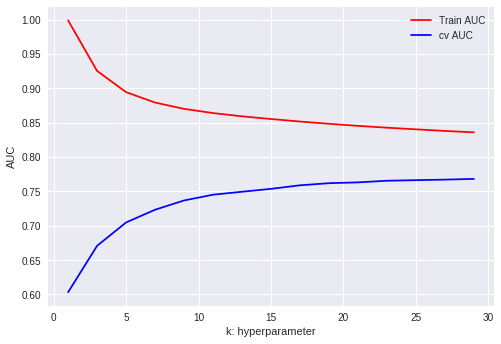

In [ ]:
knn = KNeighborsClassifier(algorithm='kd_tree')

param = {'n_neighbors':np.arange(1,30,2)}
gs= GridSearchCV(knn,param,cv=3,verbose=1,scoring='roc_auc',n_jobs=-1)
gs.fit(X_train_bow,y_train_bow)
print("Best HyperParameter: ",gs.best_params_)
print("Best Accuracy: %.2f%%"%(gs.best_score_*100))

train_auc= gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score']

lines=plt.plot(param['n_neighbors'],train_auc,param['n_neighbors'], cv_auc)
plt.setp(lines[0],color='r',label='Train AUC')
plt.setp(lines[1],color='b',label='cv AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=29,algorithm='kd_tree')
knn.fit(X_train_bow,y_train_bow)
y_pred_bow = knn.predict(X_test_bow)
y_pred_tr = knn.predict(X_train_bow)

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
acc=accuracy_score(y_test_bow, y_pred_bow)*100
ps=precision_score(y_test_bow, y_pred_bow)*100
rc=recall_score(y_test_bow, y_pred_bow)*100
f1=f1_score(y_test_bow, y_pred_bow)*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 84.44%
Precision on test set: 84.61%
recall score on test set: 99.56%
f1 score on test set: 91.48%


**Train confusion matrix**

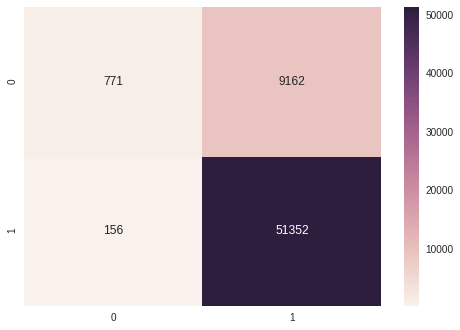

In [ ]:
cm= pd.DataFrame(confusion_matrix(y_train_bow, y_pred_tr), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

**Test confusion matrix**

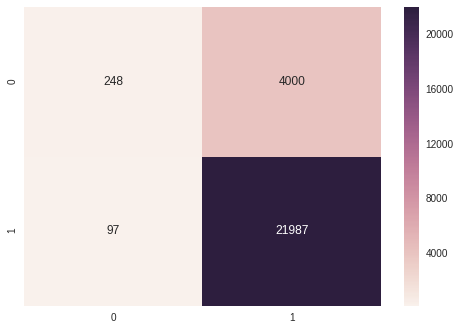

In [ ]:
cm= pd.DataFrame(confusion_matrix(y_test_bow, y_pred_bow), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

train auc =0.8463176451441088
test auc=0.7781044548361998


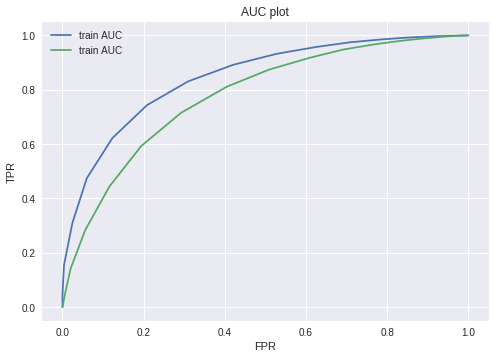

In [ ]:
train_fpr, train_tpr, thresholds = roc_curve(y_train_bow, knn.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_bow, knn.predict_proba(X_test_bow)[:,1])
print("train auc ={}".format(roc_auc_score(y_train_bow, knn.predict_proba(X_train_bow)[:,1])))
print("test auc={}".format(roc_auc_score(y_test_bow, knn.predict_proba(X_test_bow)[:,1])))

plt.plot(train_fpr, train_tpr, label="train AUC ")
plt.plot(test_fpr, test_tpr, label="train AUC ")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC plot")
plt.show()

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [ ]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,random_state=0)

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10 , max_features=500)
tf_idf_vect.fit(X_train_tf)

X_train_tf = tf_idf_vect.transform(X_train_tf)
X_test_tf = tf_idf_vect.transform(X_test_tf)

ss = StandardScaler(with_mean = False)
X_train_tf = ss.fit_transform(X_train_tf)
X_test_tf = ss.transform(X_test_tf)

print(X_train_tf.shape)
print(X_test_tf.shape)

(61441, 500)
(26332, 500)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 64.7min finished


Best HyperParameter:  {'n_neighbors': 7}
Best Accuracy: 61.50%


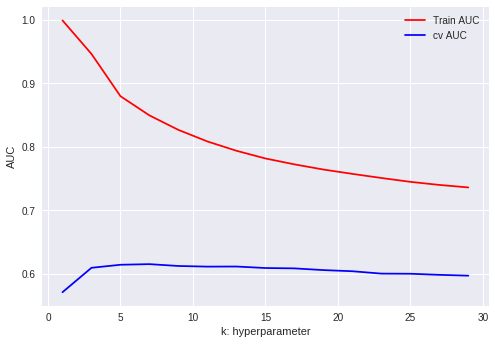

In [ ]:
knn = KNeighborsClassifier(algorithm='kd_tree')

param = {'n_neighbors':np.arange(1,30,2)}
gs = GridSearchCV(knn,param,cv=3,verbose=1,scoring='roc_auc',n_jobs=-1)
gs.fit(X_train_tf,y_train_tf)
print("Best HyperParameter: ",gs.best_params_)
print("Best Accuracy: %.2f%%"%(gs.best_score_*100))

train_auc = gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score']

lines=plt.plot(param['n_neighbors'],train_auc,param['n_neighbors'], cv_auc)
plt.setp(lines[0],color='r',label='Train AUC')
plt.setp(lines[1],color='b',label='cv AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7,algorithm='kd_tree')
knn.fit(X_train_tf,y_train_tf)
y_pred_tf = knn.predict(X_test_tf)
y_pred_tr = knn.predict(X_train_tf)

acc=accuracy_score(y_test_tf, y_pred_tf)*100
ps=precision_score(y_test_tf, y_pred_tf)*100
rc=recall_score(y_test_tf, y_pred_tf)*100
f1=f1_score(y_test_tf, y_pred_tf)*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 84.13%
Precision on test set: 84.91%
recall score on test set: 98.60%
f1 score on test set: 91.25%


**Train confusion matrix**

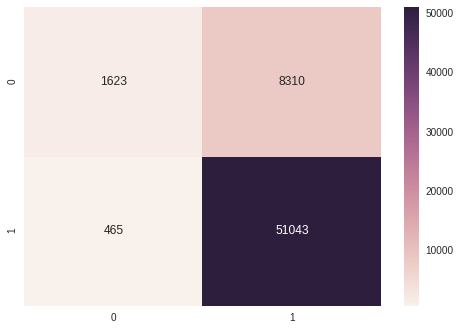

In [ ]:
cm= pd.DataFrame(confusion_matrix(y_train_tf, y_pred_tr), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

**Test confusion matrix**

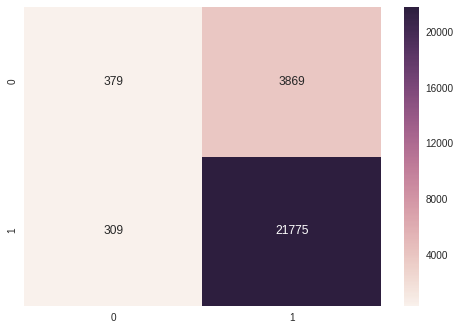

In [ ]:
cm= pd.DataFrame(confusion_matrix(y_test_tf, y_pred_tf), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

train auc =0.8581920119753033
test auc=0.6379301074718648


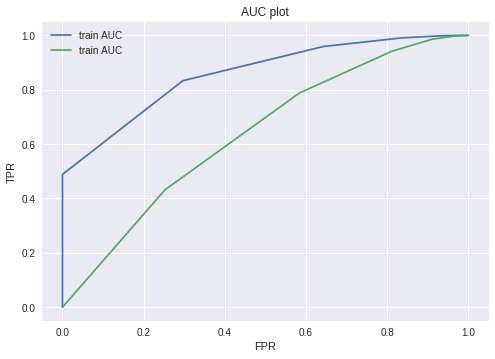

In [ ]:
from sklearn.metrics import roc_auc_score
train_fpr, train_tpr, thresholds = roc_curve(y_train_tf, knn.predict_proba(X_train_tf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_tf, knn.predict_proba(X_test_tf)[:,1])
print("train auc ={}".format(roc_auc_score(y_train_tf, knn.predict_proba(X_train_tf)[:,1])))
print("test auc={}".format(roc_auc_score(y_test_tf, knn.predict_proba(X_test_tf)[:,1])))

plt.plot(train_fpr, train_tpr, label="train AUC ")
plt.plot(test_fpr, test_tpr, label="train AUC ")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC plot")
plt.show()

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
X_train_avg, X_test_avg, y_train_avg, y_test_avg = train_test_split(np.array(sent_vectors),final['Score'].values,test_size=0.3,random_state=0)

ss = StandardScaler(with_mean = False)
X_train_avg = ss.fit_transform(X_train_avg)
X_test_avg = ss.transform(X_test_avg)

print(X_train_avg.shape)
print(X_test_avg.shape)

(61441, 50)
(26332, 50)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 196.5min finished


Best HyperParameter:  {'n_neighbors': 29}
Best Accuracy: 88.52%


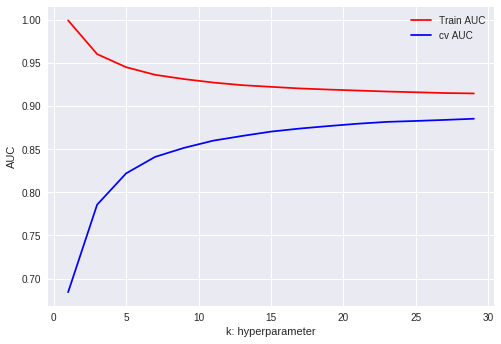

In [ ]:
knn = KNeighborsClassifier(algorithm='kd_tree')

param = {'n_neighbors':np.arange(1,30,2)}
gs = GridSearchCV(knn,param,cv=3,verbose=1,scoring='roc_auc',n_jobs=-1)
gs.fit(X_train_avg,y_train_avg)
print("Best HyperParameter: ",gs.best_params_)
print("Best Accuracy: %.2f%%"%(gs.best_score_*100))

train_auc = gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score']

lines=plt.plot(param['n_neighbors'],train_auc,param['n_neighbors'], cv_auc)
plt.setp(lines[0],color='r',label='Train AUC')
plt.setp(lines[1],color='b',label='cv AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=29,algorithm='kd_tree')
knn.fit(X_train_avg,y_train_avg)
y_pred_avg = knn.predict(X_test_avg)
y_pred_tr = knn.predict(X_train_avg)

acc=accuracy_score(y_test_avg, y_pred_avg)*100
ps=precision_score(y_test_avg, y_pred_avg)*100
rc=recall_score(y_test_avg, y_pred_avg)*100
f1=f1_score(y_test_avg, y_pred_avg)*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 87.58%
Precision on test set: 88.28%
recall score on test set: 98.24%
f1 score on test set: 92.99%


**Train confusion matrix**

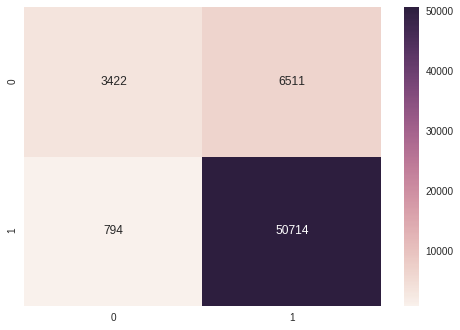

In [ ]:
cm= pd.DataFrame(confusion_matrix(y_train_avg, y_pred_tr), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

**Test confusion matrix**

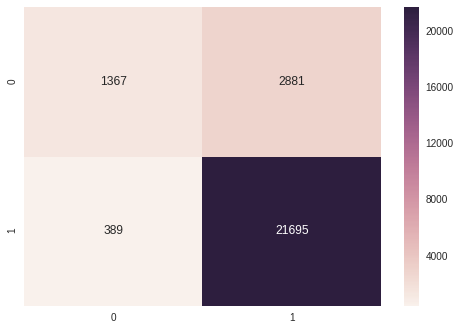

In [ ]:
cm= pd.DataFrame(confusion_matrix(y_test_avg, y_pred_avg), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

train auc =0.9165623185867954
test auc=0.8873905224394036


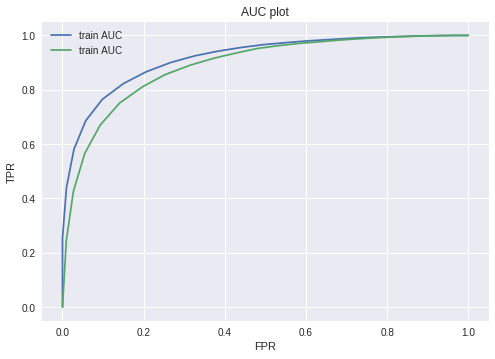

In [ ]:
train_fpr, train_tpr, thresholds = roc_curve(y_train_avg, knn.predict_proba(X_train_avg)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_avg, knn.predict_proba(X_test_avg)[:,1])
print("train auc ={}".format(roc_auc_score(y_train_avg, knn.predict_proba(X_train_avg)[:,1])))
print("test auc={}".format(roc_auc_score(y_test_avg, knn.predict_proba(X_test_avg)[:,1])))

plt.plot(train_fpr, train_tpr, label="train AUC ")
plt.plot(test_fpr, test_tpr, label="train AUC ")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC plot")
plt.show()

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
X_train_tw, X_test_tw, y_train_tw, y_test_tw = train_test_split(np.array(tfidf_sent_vectors),final['Score'].values,test_size=0.3,random_state=0)

ss = StandardScaler(with_mean = False)
X_train_tw = ss.fit_transform(X_train_tw)
X_test_tw = ss.transform(X_test_tw)

print(X_train_tw.shape)
print(X_test_tw.shape)

(61441, 50)
(26332, 50)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 165.9min finished


Best HyperParameter:  {'n_neighbors': 29}
Best Accuracy: 85.24%


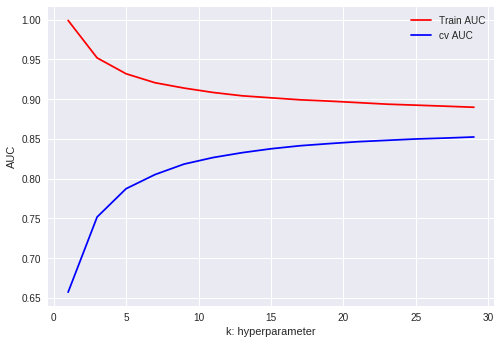

In [ ]:
knn = KNeighborsClassifier(algorithm='kd_tree')

param = {'n_neighbors':np.arange(1,30,2)}
gs = GridSearchCV(knn,param,cv=3,verbose=1,scoring='roc_auc',n_jobs=-1)
gs.fit(X_train_tw,y_train_tw)
print("Best HyperParameter: ",gs.best_params_)
print("Best Accuracy: %.2f%%"%(gs.best_score_*100))

train_auc = gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score']

lines=plt.plot(param['n_neighbors'],train_auc,param['n_neighbors'], cv_auc)
plt.setp(lines[0],color='r',label='Train AUC')
plt.setp(lines[1],color='b',label='cv AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=29,algorithm='kd_tree')
knn.fit(X_train_tw,y_train_tw)
y_pred_tw = knn.predict(X_test_tw)
y_pred_tr = knn.predict(X_train_tw)

acc=accuracy_score(y_test_tw, y_pred_tw)*100
ps=precision_score(y_test_tw, y_pred_tw)*100
rc=recall_score(y_test_tw, y_pred_tw)*100
f1=f1_score(y_test_tw, y_pred_tw)*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 86.85%
Precision on test set: 87.47%
recall score on test set: 98.42%
f1 score on test set: 92.62%


**Train confusion matrix**

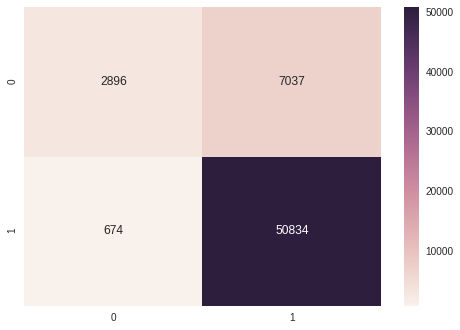

In [ ]:
cm= pd.DataFrame(confusion_matrix(y_train_tw, y_pred_tr), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

**Test confusion matrix**

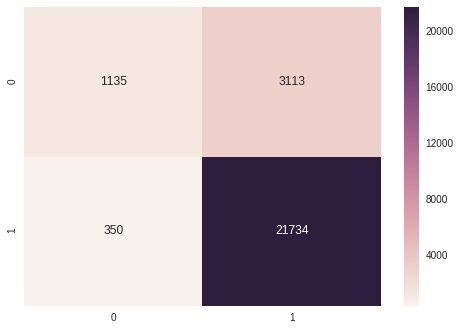

In [ ]:
cm= pd.DataFrame(confusion_matrix(y_test_tw, y_pred_tw), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

train auc =0.8959309328703289
test auc=0.8549463734342867


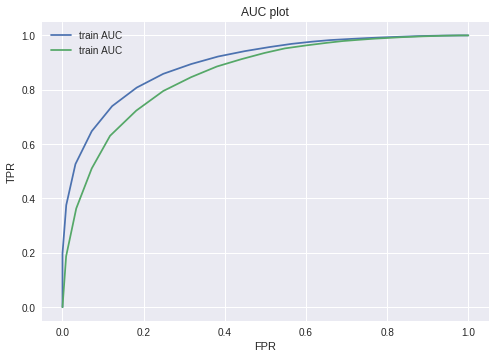

In [ ]:
from sklearn.metrics import roc_auc_score
train_fpr, train_tpr, thresholds = roc_curve(y_train_tw, knn.predict_proba(X_train_tw)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_tw, knn.predict_proba(X_test_tw)[:,1])
print("train auc ={}".format(roc_auc_score(y_train_tw, knn.predict_proba(X_train_tw)[:,1])))
print("test auc={}".format(roc_auc_score(y_test_tw, knn.predict_proba(X_test_tw)[:,1])))

plt.plot(train_fpr, train_tpr, label="train AUC ")
plt.plot(test_fpr, test_tpr, label="train AUC ")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC plot")
plt.show()

# [6] Conclusions

In [ ]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["S.NO.", "MODEL","Featurization", "Best K", "Test AUC","F1-Score"]
x.add_row(["1", "brute force", "BOW","13","71.25%", "91.41%"])
x.add_row(["2", "brute force", "TFIDF","3","57.53%", "90.99%"])
x.add_row(["3", "brute force", "AVG W2V","29","88.90%", "93.05%"])
x.add_row(["4", "brute force", "TFIDF W2V","29","85.655%", "92.64%"])
x.add_row(["5", "Kd tree", "BOW","29","77.81%", "91.48%"])
x.add_row(["6", "Kd tree", "TFIDF","7","63.79%", "91.25%"])
x.add_row(["7", "Kd tree", "AVG W2V","29","88.73%", "92.99%"])
x.add_row(["8", "Kd tree", "TFIDF W2V","29","85.49%", "92.62%"])

print(x)

+-------+-------------+---------------+--------+----------+----------+
| S.NO. |    MODEL    | Featurization | Best K | Test AUC | F1-Score |
+-------+-------------+---------------+--------+----------+----------+
|   1   | brute force |      BOW      |   13   |  71.25%  |  91.41%  |
|   2   | brute force |     TFIDF     |   3    |  57.53%  |  90.99%  |
|   3   | brute force |    AVG W2V    |   29   |  88.90%  |  93.05%  |
|   4   | brute force |   TFIDF W2V   |   29   | 85.655%  |  92.64%  |
|   5   |   Kd tree   |      BOW      |   29   |  77.81%  |  91.48%  |
|   6   |   Kd tree   |     TFIDF     |   7    |  63.79%  |  91.25%  |
|   7   |   Kd tree   |    AVG W2V    |   29   |  88.73%  |  92.99%  |
|   8   |   Kd tree   |   TFIDF W2V   |   29   |  85.49%  |  92.62%  |
+-------+-------------+---------------+--------+----------+----------+


1)KNN is a very slow Algorithm compared to other algoritms.

2)Both brute force and kd tree gives similar results.

3)Best Test AUC of 88.90% is achieved by brute force AVG W2V.

4)Best F1-Score of 93.05% is also obtained by brute force AVG W2V.

5)TFIDF W2V for both brute force and kd tree has also given good results.